Link to the competition: https://tianchi.aliyun.com/competition/entrance/231705/introduction

In [216]:
import sys
import pickle
import warnings
import spacy
import time
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np
import pandas as pd 
import json
import seaborn as sns
from keras import optimizers
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models import LdaModel, TfidfModel
import pyLDAvis.gensim as gensimvis
import pyLDAvis
from spacy.tokens import Token
from spacy.lang.en.stop_words import STOP_WORDS  # import stop words from language data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from utils.plot_functions import *
%matplotlib inline
nlp = spacy.load("en_core_web_sm")
pd.set_option('display.max_colwidth', 500)
%load_ext autoreload
%autoreload 2
if not sys.warnoptions:
    warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
def extract_tweet_id(link):
    try:
        return int(link.split('/')[-1])
    except:
        return -1

# Load Raw Data

In [6]:
df_train = pd.read_table('./data/[Updated] Training Set for Competition.txt',sep='\t')

In [7]:
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%d.%m.%Y').dt.date
df_train['Event ID'] = df_train['Event ID'].fillna(0)
df_train['Is_Food'] = df_train['Event ID'] > 0
df_train['tweet_id'] = df_train['Link'].apply(extract_tweet_id)

In [8]:
df_train.head(3)

,Date,Time,Trainig/Test,Event ID,Title,Link,Abstract,Is_Food,tweet_id
0,2019-02-05,18:45:44,Training,1.0,New dog food recall and latest warning on grain-free foods #SmartNews,https://twitter.com/tweet/status/1092857075753861125,New dog food recall and latest warning on grain-free foods #SmartNews https://t.co/nS49e7r63l,True,1092857075753861125
1,2019-02-05,06:29:38,Training,1.0,New Dog Food Recall And The Latest Warning On Grain-Free Foods... https://t.co/brx3qW4t4L,https://twitter.com/tweet/status/1092671572400373760,New Dog Food Recall And The Latest Warning On Grain-Free Foods... https://t.co/brx3qW4t4L https://t.co/5XcIAt9g4p,True,1092671572400373760
2,2019-02-05,18:40:20,Training,1.0,RT @BaybeeReade: Another dog food recall over dangerous levels of vitamin D - Fox News,https://twitter.com/tweet/status/1092855599233150977,RT @BaybeeReade: Another dog food recall over dangerous levels of vitamin D - Fox News https://t.co/z0w17ubVay,True,1092855599233150977


In [9]:
df_test = pd.read_table('./data/[Updated] Test Set for Competition.txt',sep='\t')
df_test['tweet_id'] = df_test['Link'].apply(extract_tweet_id)

In [10]:
df_test.head(3)

,Date,Time,Training/Test,Title,Link,Abstract,tweet_id
0,2019-03-07,23:59:31,Test,@pccs_heron Salmonella,https://twitter.com/tweet/status/1103807421800202242,@pccs_heron Salmonella,1103807421800202242
1,2019-03-07,23:59:20,Test,@richardlanigan @trishgreenhalgh No. It's not feaces alone. Not at all. Polio virus is transmitted by the feacal…,https://twitter.com/tweet/status/1103807373196623873,@richardlanigan @trishgreenhalgh No. It's not feaces alone. Not at all. Polio virus is transmitted by the feacal… https://t.co/8ziThZHccA,1103807373196623873
2,2019-03-07,23:59:02,Test,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOnSecurity For a while I thought I was allergic to water because of the…,https://twitter.com/tweet/status/1103807299389349889,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOnSecurity For a while I thought I was allergic to water because of the… https://t.co/XoMGCuQLcs,1103807299389349889


# Distribution on Train data

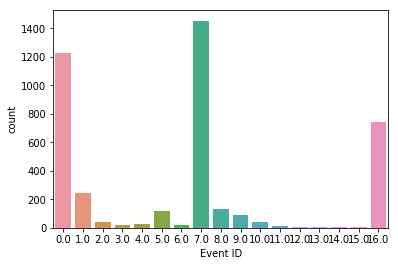

In [14]:
sns.countplot(x='Event ID', data=df_train)

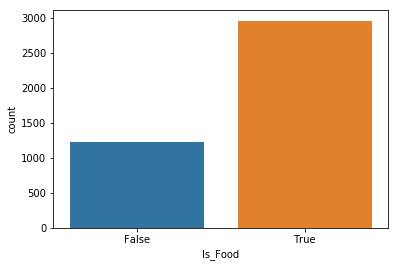

In [15]:
sns.countplot(x='Is_Food', data=df_train)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

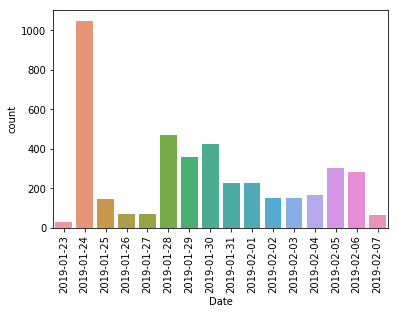

In [16]:
sns.countplot(x='Date', data=df_train, order = sorted(set(df_train['Date'])))
plt.xticks(rotation=90)

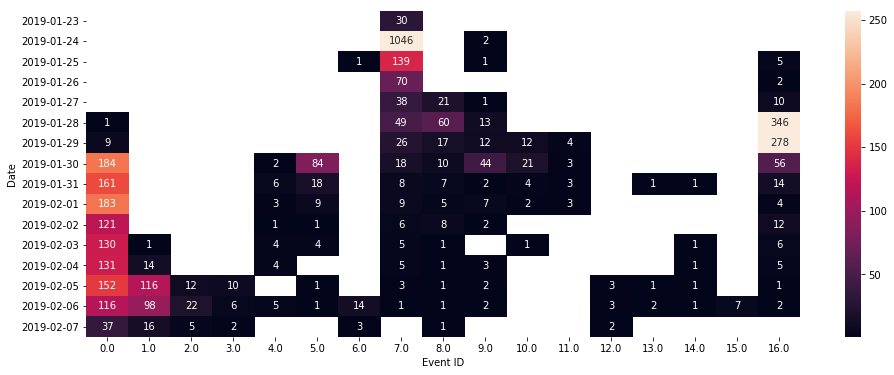

In [17]:
plt.figure(figsize=(16, 6))
pivot = df_train.groupby(['Date','Event ID'], as_index=False)['Link'].\
            agg({'count':len}).\
            pivot('Date','Event ID','count')
sns.heatmap(pivot, robust=True, annot=True, fmt='.4g')

# NLP on Abstract

## Remove stop words, and tokenize

In [18]:
stop_words_getter = lambda token: token.is_stop or token.lemma_ in STOP_WORDS
Token.set_extension('is_stop', getter=stop_words_getter, force=True)  # set attribute with getter

In [19]:
def filter_token(token):
    if(token.is_punct or \
       token.is_digit or \
       token.is_space or \
       token.like_num or \
       not token.text.isalpha() or \
       token.lemma_ == '-PRON-' or \
       'http' in token.text or \
       '@' in token.text or \
       "’s" in token.text or \
       "'s" in token.text or \
       token.text == 'rt' or \
       len(token.text) <= 1 or \
       token._.is_stop):
        return(False)
    else:
        return(True)

In [20]:
def clean(text):
    return [token.lemma_ for token in nlp(str(text).lower()) if filter_token(token)]

### Train

In [21]:
%%time
temp = []
for text in log_progress(df_train['Abstract'], every = 100):
    temp.append(clean(text))
df_train['ab_clean'] = temp

CPU times: user 3min 17s, sys: 25.8 s, total: 3min 42s
Wall time: 37.8 s


In [22]:
df_train[['Abstract','ab_clean']].head(3)

,Abstract,ab_clean
0,New dog food recall and latest warning on grain-free foods #SmartNews https://t.co/nS49e7r63l,"[new, dog, food, recall, late, warning, grain, free, food, smartnew]"
1,New Dog Food Recall And The Latest Warning On Grain-Free Foods... https://t.co/brx3qW4t4L https://t.co/5XcIAt9g4p,"[new, dog, food, recall, late, warning, grain, free, food]"
2,RT @BaybeeReade: Another dog food recall over dangerous levels of vitamin D - Fox News https://t.co/z0w17ubVay,"[dog, food, recall, dangerous, level, vitamin, fox, news]"


### Test

In [23]:
%%time
temp = []
for text in log_progress(df_test['Abstract'], every = 100):
    temp.append(clean(text))
df_test['ab_clean'] = temp

CPU times: user 16min 18s, sys: 1min 57s, total: 18min 15s
Wall time: 3min 4s


In [24]:
df_test[['Abstract','ab_clean']].head(3)

,Abstract,ab_clean
0,@pccs_heron Salmonella,[salmonella]
1,@richardlanigan @trishgreenhalgh No. It's not feaces alone. Not at all. Polio virus is transmitted by the feacal… https://t.co/8ziThZHccA,"[feace, polio, virus, transmit, feacal]"
2,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOnSecurity For a while I thought I was allergic to water because of the… https://t.co/XoMGCuQLcs,"[think, allergic, water]"


## Apply Phrase model

In [25]:
bigram_model = Phraser(Phrases(list(df_train['ab_clean']) + list(df_test['ab_clean'])))

In [26]:
df_train['ab_clean_ph'] = df_train['ab_clean'].apply(lambda text: bigram_model[text])
df_test['ab_clean_ph']  = df_test['ab_clean'].apply(lambda text: bigram_model[text])

In [27]:
df_train[['Abstract','ab_clean','ab_clean_ph']].head(3)

,Abstract,ab_clean,ab_clean_ph
0,New dog food recall and latest warning on grain-free foods #SmartNews https://t.co/nS49e7r63l,"[new, dog, food, recall, late, warning, grain, free, food, smartnew]","[new, dog, food, recall, late_warning, grain_free, food, smartnew]"
1,New Dog Food Recall And The Latest Warning On Grain-Free Foods... https://t.co/brx3qW4t4L https://t.co/5XcIAt9g4p,"[new, dog, food, recall, late, warning, grain, free, food]","[new, dog, food, recall, late_warning, grain_free, food]"
2,RT @BaybeeReade: Another dog food recall over dangerous levels of vitamin D - Fox News https://t.co/z0w17ubVay,"[dog, food, recall, dangerous, level, vitamin, fox, news]","[dog, food, recall, dangerous_level, vitamin_fox, news]"


In [28]:
df_test[['Abstract','ab_clean','ab_clean_ph']].head(3)

,Abstract,ab_clean,ab_clean_ph
0,@pccs_heron Salmonella,[salmonella],[salmonella]
1,@richardlanigan @trishgreenhalgh No. It's not feaces alone. Not at all. Polio virus is transmitted by the feacal… https://t.co/8ziThZHccA,"[feace, polio, virus, transmit, feacal]","[feace, polio, virus, transmit, feacal]"
2,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOnSecurity For a while I thought I was allergic to water because of the… https://t.co/XoMGCuQLcs,"[think, allergic, water]","[think, allergic, water]"


## Highlight zero length abstract

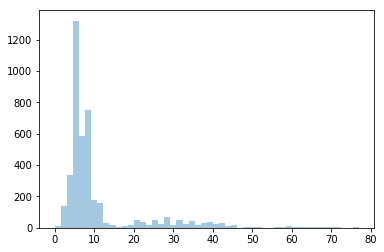

In [29]:
sns.distplot([len(x) for x in df_train['ab_clean_ph']], kde = False)

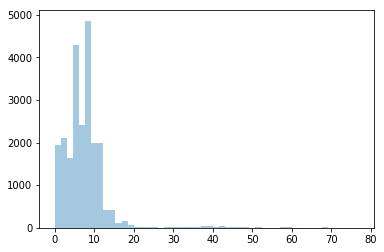

In [30]:
sns.distplot([len(x) for x in df_test['ab_clean_ph']], kde = False)

In [31]:
df_train['zero_length'] = df_train['ab_clean_ph'].apply(lambda x: True if len(x) == 0 or x == ['nan'] else False)
df_test['zero_length'] = df_test['ab_clean_ph'].apply(lambda x: True if len(x) == 0 or x == ['nan'] else False)

In [32]:
print(sum(df_train['zero_length']), 'zero length cleaned abstract in training set.')
print(sum(df_test['zero_length']), 'zero length cleaned abstract in test set.')

8 zero length cleaned abstract in training set.
1443 zero length cleaned abstract in test set.


# Web Scraping

In [ ]:
!pip install Twython

In [48]:
from twython import Twython
with open('api_key.txt','r') as inf:
    key_dict = eval(inf.read())

In [49]:
CONSUMER_KEY = key_dict['CONSUMER_KEY']
CONSUMER_SECRET = key_dict['CONSUMER_SECRET']
OAUTH_TOKEN = key_dict['OAUTH_TOKEN']
OAUTH_TOKEN_SECRET = key_dict['OAUTH_TOKEN_SECRET']
twitter = Twython(
    CONSUMER_KEY, CONSUMER_SECRET,
    OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

In [103]:
def add_more_info(tweet_id):
    r = {
        'tweet_found':True,
        'user_name':'',
        'mentions':[],
        'medias':None,
        'hashtags':[],
        'in_reply_to_status_id':None,
        'in_reply_to_screen_name':None,
        'in_reply_to_status_text':None
    }
    
    if tweet_id == -1:
        return r
    
    flag = True
    while(flag):
        try:
            tweet = twitter.show_status(id=tweet_id)
            flag = False

        except Exception as e:
            if e.msg != 'Twitter API returned a 429 (Too Many Requests), Rate limit exceeded':
                r['tweet_found'] = False
                flag = False
                return r
            else:
                print(e.msg)
                print('Sleeping for a min ......')
                time.sleep(60)
                
    r['user_name'] = tweet['user']['name']
    r['mentions'] = [v for mention in tweet['entities']['user_mentions'] for k,v in mention.items() if k == 'screen_name'] 
    try:
        r['medias'] = [v for media in tweet['entities']['media'] for k,v in media.items() if k == 'media_url']
    except:
        pass
    r['hashtags'] = [v for mention in tweet['entities']['hashtags'] for k,v in mention.items() if k == 'text']
    r['in_reply_to_status_id'] = tweet['in_reply_to_status_id']
    r['in_reply_to_screen_name'] = tweet['in_reply_to_screen_name']
    if r['in_reply_to_status_id'] is not None:
        try:
            main_tweet = twitter.show_status(id=r['in_reply_to_status_id'])
            r['in_reply_to_status_text'] = main_tweet['text']
        except:
            pass
    
    return r

## Train

In [ ]:
extra_infos = []
for tweet_id in log_progress(df_train['tweet_id'][3400:] , every = 1):
    extra_infos.append(add_more_info(tweet_id))

In [110]:
df_train_merge = pd.concat([df_train, pd.DataFrame(extra_infos)], axis = 1)

In [112]:
df_train_merge.to_csv('./processed_data/train_with_scraping.csv', index = False)

## Test

In [ ]:
extra_infos = []
for tweet_id in log_progress(df_test['tweet_id'] , every = 1):
    extra_infos.append(add_more_info(tweet_id))

In [115]:
df_extra_infos = pd.DataFrame(extra_infos)
df_test_merge = pd.concat([df_test, df_extra_infos], axis = 1)

In [116]:
df_test_merge.to_csv('./processed_data/test_with_scraping.csv', index = False)

# Try: Explore what makes a news `Is_Food`

## NLP Features

### Verbs

In [397]:
def get_verb(text):
    try:
        doc = nlp(text)
        output = []
        for token in doc:
            if token.pos_ in ['VERB']:
                output.append(token.lemma_)
        return output
    except:
        return []

In [400]:
%%time
df_train_merge['verbs'] = df_train_merge['Abstract'].apply(get_verb)

CPU times: user 3min 31s, sys: 30.3 s, total: 4min 1s
Wall time: 41 s


In [403]:
y_1_verbs = [xx for x in df_train_merge[df_train_merge['Event ID'] >= 1]['verbs'] for xx in x if x ]
y_0_verbs = [xx for x in df_train_merge[df_train_merge['Event ID'] == 0]['verbs'] for xx in x if x ]

In [404]:
pd.Series(y_0_verbs).value_counts().head(15)

be        913
have      273
get       221
eat       173
do        161
can       105
will       79
come       53
say        52
make       51
die        48
would      47
’          47
recall     47
go         44
dtype: int64

In [426]:
pd.Series(y_1_verbs).value_counts().head(30)

recall         2173
be             1637
have            761
sell            362
say             311
use             278
issue           241
announce        220
may             179
fear            166
discover        166
receive         159
confirm         146
should          132
contaminate     113
contain         104
discard          99
check            91
relate           78
find             78
affect           70
can              67
sample           57
could            52
eat              47
concern          40
get              35
include          35
publish          35
do               35
dtype: int64

### Noun

In [409]:
def get_noun_chunk(text):
    try:
        doc = nlp(text)
        output = []
        for chunk in doc.noun_chunks:
            output.append(chunk.root.text)
        return output
    except:
        return []

In [410]:
%%time
df_train_merge['nouns'] = df_train_merge['Abstract'].apply(get_noun_chunk)

CPU times: user 3min 16s, sys: 25.3 s, total: 3min 41s
Wall time: 37.4 s


In [411]:
y_1_nouns = [xx for x in df_train_merge[df_train_merge['Event ID'] >= 1]['nouns'] for xx in x if x ]
y_0_nouns = [xx for x in df_train_merge[df_train_merge['Event ID'] == 0]['nouns'] for xx in x if x ]

In [419]:
pd.Series(y_0_nouns).value_counts().head(30)

salmonella       384
I                228
you              176
it               162
dough            114
i                101
food             100
chicken           79
me                74
Salmonella        67
eggs              63
outbreaks         56
RT                49
we                49
side              49
people            46
they              46
outbreak          43
It                40
hedgehogs         37
salmon            37
recall            37
CDC               37
products          34
meat              28
contamination     28
You               28
coli              27
Outbreak          27
quarter           27
dtype: int64

In [418]:
pd.Series(y_1_nouns).value_counts().head(30)

Mills            1437
bags              985
flour             928
Flour             722
recall            634
concerns          561
nectarines        508
plums             363
product           323
contamination     306
Peaches           294
salmonella        280
date              261
it                261
Walmart           258
company           257
April             238
Salmonella        205
Listeria          195
RECALL            195
ALERT             187
peaches           187
fears             171
food              166
Costco            160
reports           159
stores            157
illnesses         146
Medal             141
Foods             140
dtype: int64

### NNP

In [427]:
def get_nnp(text):
    try:
        doc = nlp(text)
        for token in doc:
            if token.tag_ in ['NNP']:
                return True
        return False
    except:
        return False

In [433]:
%%time
df_train_merge['nnp'] = df_train_merge['Abstract'].apply(get_nnp)

CPU times: user 3min 14s, sys: 25.7 s, total: 3min 40s
Wall time: 37.3 s


In [436]:
y_1_nnp = df_train_merge[df_train_merge['Event ID'] >= 1]['nnp'] 
y_0_nnp = df_train_merge[df_train_merge['Event ID'] == 0]['nnp']

In [437]:
pd.Series(y_0_nnp).value_counts()

True     837
False    388
Name: nnp, dtype: int64

In [438]:
pd.Series(y_1_nnp).value_counts()

True     2848
False     110
Name: nnp, dtype: int64

## Words

In [305]:
all_events_top_words = dict()
for event_id in range(16):
    event_subset = df_train[df_train['Event ID'] == event_id]
    corpus = list(event_subset['ab_clean_ph'].apply(lambda x: ' '.join(x)))
    vectorizer = CountVectorizer(binary = True) # if in sentence or not
    X = vectorizer.fit_transform(corpus)
    words = vectorizer.get_feature_names()
    frequencies = X.toarray().sum(axis = 0)
    word_freq = {k:v for k, v in zip(words, frequencies)}
    word_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)
    all_events_top_words['Event ID: '+ str(event_id)] = word_freq[:10]

For each event, what is the top 10 words in terms of corpus frequency
- Event ID = 0 means not a labeled event

In [306]:
all_events_top_words = pd.DataFrame(all_events_top_words)
all_events_top_words

,Event ID: 0,Event ID: 1,Event ID: 2,Event ID: 3,Event ID: 4,Event ID: 5,Event ID: 6,Event ID: 7,Event ID: 8,Event ID: 9,Event ID: 10,Event ID: 11,Event ID: 12,Event ID: 13,Event ID: 14,Event ID: 15
0,"(salmonella, 638)","(food, 240)","(frito_lie, 26)","(food, 18)","(aflatoxin, 19)","(chicken_nugget, 95)","(gorgonzola_dop, 13)","(general_mill, 1297)","(recall, 122)","(nut_butter, 66)","(recall, 33)","(crisp_delicious, 10)","(feta, 8)","(ground_turkey, 4)","(honey_smack, 5)","(brie_cheese, 7)"
1,"(food, 185)","(recall, 219)","(recall, 25)","(allergy_alert, 16)","(peanut_butter, 12)","(tyson, 94)","(presenza_di, 11)","(recall, 1187)","(baby_spinach, 96)","(possible_listeria, 44)","(chicken_nugget, 30)","(recall, 10)","(recall, 8)","(jennie, 4)","(kellogg, 5)","(england, 7)"
2,"(outbreak, 119)","(dog, 163)","(stacy_simply, 23)","(issue_santa, 16)","(butter, 11)","(food, 93)","(listeria, 10)","(flour, 1105)","(food, 76)","(oskri_recall, 41)","(food, 27)","(brand, 8)","(contamination, 7)","(recall_pound, 4)","(cereal, 4)","(recall, 7)"
3,"(chicken, 110)","(hill_pet, 64)","(naked_pita, 19)","(rosa, 16)","(kenya, 9)","(recall, 81)","(dolce, 9)","(gold_medal, 525)","(salmonella, 59)","(recall, 31)","(perdue, 27)","(nugget, 8)","(cheese, 6)","(outbreak, 3)","(outbreak, 3)","(warning, 7)"
4,"(recall, 101)","(pet, 45)","(chip, 18)","(walnut_milk, 16)","(nuteez_peanut, 8)","(recall_pound, 48)","(marchi, 9)","(salmonella_concern, 503)","(possible_salmonella, 53)","(listeria, 22)","(fun_shape, 12)","(salmonella, 8)","(garlic, 4)","(salmonella, 3)","(recall, 3)","(listeria_monocytogene, 5)"
5,"(eat, 83)","(vitamin, 38)","(undeclared_milk, 18)","(market_undeclared, 15)","(contaminate_peanut, 7)","(contamination, 27)","(lotti_di, 8)","(bag_gold, 460)","(contamination, 49)","(thrive_market, 22)","(chicken_breast, 11)","(chicken_breast, 7)","(health, 4)","(widen, 3)","(salmonella, 3)","(affect, 3)"
6,"(cookie_dough, 80)","(nutrition, 33)","(allergy_alert, 15)","(egg_hipster, 11)","(find, 7)","(possible_rubber, 25)","(lotti, 7)","(medal_unbleached, 389)","(spinach, 34)","(butter, 18)","(undeclared_allergen, 10)","(chicken_nugget, 5)","(herb, 4)","(washington_post, 2)","(product, 2)","(batch, 2)"
7,"(eat_raw, 67)","(hill_dog, 30)","(issue_voluntary, 15)","(chipster, 5)","(food, 7)","(recall_alert, 25)","(il, 6)","(salmonella, 378)","(state, 33)","(contamination, 12)","(undeclared_milk, 10)","(food, 5)","(maleny, 4)","(cgan, 1)","(state, 2)","(find, 2)"
8,"(egg, 63)","(pet_owner, 28)","(pita_chip, 14)","(egg, 5)","(brand, 6)","(nugget, 23)","(richiamato, 6)","(salmonella_fear, 314)","(product, 24)","(recall_nut, 10)","(allergen, 8)","(canada, 3)","(advice, 3)","(icc, 1)","(accord, 1)","(listeria, 2)"
9,"(listeria, 58)","(voluntary_recall, 23)","(small_number, 13)","(chipster_cookie, 4)","(government, 5)","(rubber, 20)","(di, 5)","(unbleached_flour, 312)","(product_contain, 22)","(fruit_nut, 9)","(allergy, 6)","(canadian, 3)","(alert, 3)","(salmonella_concern, 1)","(amid_salmonella, 1)","(money, 2)"


## Hashtags

In [266]:
y_1_tags = [xx for x in df_train_merge[df_train_merge['Event ID'] >= 1]['hashtags'] for xx in x if x ]
y_0_tags = [xx for x in df_train_merge[df_train_merge['Event ID'] == 0]['hashtags'] for xx in x if x ]

In [330]:
pd.Series(y_0_tags).value_counts().head(15)

Salmonella       19
ChadFact         12
foodfraud         9
CDC               9
OneHealthKIPM     8
food              8
foodsafety        8
FoodSafety        7
Listeria          6
salmonella        5
aflatoxin         5
Publix            5
Campylobacter     4
fish              3
recalls           3
dtype: int64

In [329]:
pd.Series(y_1_tags).value_counts().head(15)

RECALL        52
Recall        48
Listeria      26
salmonella    22
recall        22
SmartNews     21
foodsafety    17
recalls       16
Foodsafety    12
Salmonella    11
Walmart       10
flour          9
peaches        8
FDA            8
Flour          7
dtype: int64

## Mentions

In [269]:
y_1_mentions = [xx for x in df_train_merge[df_train_merge['Event ID'] >= 1]['mentions'] for xx in x if x ]
y_0_mentions = [xx for x in df_train_merge[df_train_merge['Event ID'] == 0]['mentions'] for xx in x if x ]

In [339]:
pd.Series(y_0_mentions).value_counts().head(15)

uk_rants           10
LivingSafely        6
HumasBKIPM          5
destinyangel5       5
AVMAvets            4
realDonaldTrump     4
GorgeousVegan       4
BKIPMBaubau         4
CNN                 4
joeschwarcz         4
Veggiefact          4
foodsafetynews      4
rinajanwar2201      4
KEBS_ke             3
DavidJNeal          3
dtype: int64

In [340]:
pd.Series(y_1_mentions).value_counts().head(15)

googlenews         16
USATODAY           14
WebMD              11
CNN                10
wusa9               8
ABC7                8
NBCNews             8
ConsumerReports     8
abc13houston        7
ABC7Chicago         7
wfaa                6
foodsafetynews      6
SFGate              6
UPI                 6
FDArecalls          5
dtype: int64

## Length of Text

In [309]:
y_1_len = df_train[df_train['Event ID'] >= 1]['ab_clean'].apply(len)
y_0_len = df_train[df_train['Event ID'] == 0]['ab_clean'].apply(len)
y_1_len_5 = y_1_len < 5
y_0_len_5 = y_0_len < 5

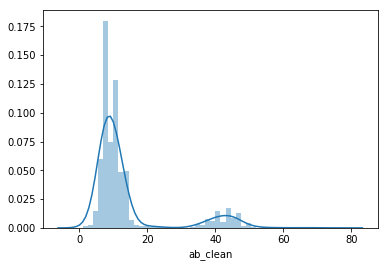

In [279]:
sns.distplot(y_1_len)

In [310]:
y_0_len_5.value_counts().head(10)

False    1117
True      108
Name: ab_clean, dtype: int64

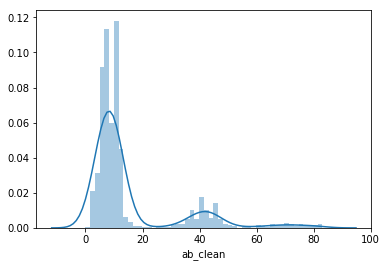

In [280]:
sns.distplot(y_0_len)

In [311]:
y_1_len_5.value_counts().head(10)

False    2922
True       36
Name: ab_clean, dtype: int64

## User Name

In [312]:
y_1_usr = [xx for x in df_train_merge[df_train_merge['Event ID'] >= 1]['user_name'].apply(lambda x:x.split(' ')) for xx in x if len(xx) > 0]
y_0_usr = [xx for x in df_train_merge[df_train_merge['Event ID'] == 0]['user_name'].apply(lambda x:x.split(' ')) for xx in x if len(xx) > 0]

In [313]:
pd.Series(y_0_usr).value_counts().head(10)

@EVKDailyMenu    43
the              20
Living           15
Food             14
Safely™          14
David            13
Chad             12
HandWashBot      12
News             10
of                8
dtype: int64

In [314]:
pd.Series(y_1_usr).value_counts().head(10)

News      228
The        41
Health     37
FOX        26
&          21
Food       21
Report     19
NBC        17
11         16
ABC        15
dtype: int64

## Media

In [296]:
y_1_media = df_train_merge[df_train_merge['Event ID'] >= 1]['medias'].apply(lambda x: len(x) if x else 0)
y_0_media = df_train_merge[df_train_merge['Event ID'] == 0]['medias'].apply(lambda x: len(x) if x else 0)

In [297]:
pd.Series(y_0_media).value_counts().head(10)

0    1172
1      53
Name: medias, dtype: int64

In [298]:
pd.Series(y_1_media).value_counts().head(10)

0    2425
1     533
Name: medias, dtype: int64

# Try: Topic Modelling on train data

useful reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

Only perform LDA on events >1

In [192]:
df_train_subset = df_train[df_train['Event ID'] >= 1]

In [193]:
dictionary = corpora.Dictionary(df_train_subset['ab_clean_ph'])
print(dictionary)

Dictionary(2415 unique tokens: ['dog', 'food', 'grain_free', 'late_warning', 'new']...)


In [194]:
dictionary.filter_extremes(no_below = 3, no_above = 0.5)
print(dictionary)

Dictionary(938 unique tokens: ['dog', 'food', 'grain_free', 'late_warning', 'new']...)


In [195]:
words = [k[1] for k in dictionary.iteritems()]

In [196]:
bow_corpus = [dictionary.doc2bow(text) for text in df_train_subset['ab_clean_ph']]
bow_corpus[0]

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1)]

In [197]:
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]
tfidf_corpus[0]

[(0, 0.2555732744587509),
 (1, 0.3042114862374455),
 (2, 0.48560482406575156),
 (3, 0.48560482406575156),
 (4, 0.42448742973688747),
 (5, 0.4362613949310077)]

In [234]:
no_topics = 16

In [235]:
%%time
lda_bow = LdaModel(bow_corpus, num_topics = no_topics, id2word = dictionary, passes = 100)
lda_tfidf = LdaModel(tfidf_corpus, num_topics = no_topics, id2word = dictionary, passes = 100)

CPU times: user 1min 41s, sys: 116 ms, total: 1min 41s
Wall time: 1min 41s


In [236]:
for i in range(no_topics):
    print('Topic:',i,lda_bow.print_topic(i, 10))

Topic: 0 0.087*"salmonella_concern" + 0.067*"flour" + 0.065*"kilogram_bag" + 0.064*"good_date" + 0.061*"april_upc" + 0.061*"code_customer" + 0.060*"discard_product" + 0.054*"company_discover" + 0.049*"salmonella_sampling" + 0.042*"general_mill"
Topic: 1 0.229*"food" + 0.131*"dog" + 0.047*"hill_pet" + 0.036*"pet" + 0.028*"vitamin" + 0.024*"nutrition" + 0.022*"hill_dog" + 0.021*"pet_owner" + 0.018*"high_level" + 0.016*"dangerous_level"
Topic: 2 0.124*"bag_gold" + 0.118*"general_mill" + 0.097*"medal_unbleached" + 0.095*"flour" + 0.057*"salmonella_concern" + 0.047*"fruit" + 0.039*"voluntarily_recall" + 0.031*"recall_pound" + 0.028*"medal_flour" + 0.025*"walmart_aldi"
Topic: 3 0.069*"general_mill" + 0.068*"flour" + 0.056*"fear" + 0.044*"salmonella_contamination" + 0.038*"issue_abundance" + 0.036*"care_general" + 0.036*"mill_receive" + 0.035*"direct_consumer" + 0.032*"illness_relate" + 0.032*"report_confirm"
Topic: 4 0.091*"unbleached_flour" + 0.087*"general_mill" + 0.084*"gold_medal" + 0.04

In [237]:
for i in range(no_topics):
    print('Topic:',i,lda_tfidf.print_topic(i, 10))

Topic: 0 0.056*"store" + 0.054*"thrive_market" + 0.036*"hill_dog" + 0.026*"listeria" + 0.026*"prompt" + 0.026*"recall_nut" + 0.025*"butter" + 0.023*"food" + 0.020*"certain" + 0.019*"recallalert"
Topic: 1 0.112*"salmonella_fear" + 0.111*"gold_medal" + 0.094*"flour" + 0.085*"general_mill" + 0.085*"bag" + 0.063*"salmonella_concern" + 0.052*"plum_nectarine" + 0.043*"unbleached_flour" + 0.036*"sell_nationwide" + 0.034*"salmonella"
Topic: 2 0.062*"dog" + 0.059*"baby_spinach" + 0.053*"food" + 0.047*"find" + 0.033*"product" + 0.031*"vitamin" + 0.028*"share" + 0.027*"read" + 0.026*"salmonella" + 0.023*"dangerous_level"
Topic: 3 0.128*"listeria" + 0.088*"peach_plum" + 0.081*"fruit_sell" + 0.080*"walmart_costco" + 0.075*"fresh_peach" + 0.075*"aldi" + 0.061*"nectarine" + 0.048*"nectarine_plum" + 0.028*"chile_recall" + 0.027*"fda"
Topic: 4 0.042*"taint" + 0.036*"voluntary_national" + 0.030*"distribute" + 0.029*"announce_today" + 0.029*"se" + 0.028*"face" + 0.026*"come" + 0.024*"late" + 0.022*"disco

# (Not used) Binary Classification Model on `Is_Food`

**Generate TF-IDF matrix**

- Without zero length abstracts

In [252]:
df_train_clean = df_train[~df_train['zero_length']]
df_test_clean = df_test[~df_test['zero_length']]

In [239]:
vectorizer = TfidfVectorizer(min_df=3, sublinear_tf=True, max_df=0.5)
corpus = list(df_train_clean['ab_clean_ph']) + list(df_test_clean['ab_clean_ph'])
vectorizer.fit([' '.join(text) for text in corpus])
X_train  = vectorizer.transform([' '.join(text) for text in df_train_clean['ab_clean_ph']])
X_test = vectorizer.transform([' '.join(text) for text in df_test_clean['ab_clean_ph']])
y_train = df_train_clean['Is_Food'].apply(lambda x: 1 if x else 0)

In [240]:
x_columns = [word for word, index in sorted(vectorizer.vocabulary_.items(), key = lambda x:x[1])]

**Fit Regularized Logistic Regression**

In [241]:
param_test_lr =  {'C' :[10 ** x for x in list(range(-3,4,1))]}
param_test_lr['C']

[0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [242]:
gsearch_lr = GridSearchCV(estimator = LogisticRegression( 
        penalty='l2', 
        solver='liblinear',
        max_iter=1000,
        class_weight = 'balanced'
    ),                   
    param_grid = param_test_lr, 
        scoring = {'AUC': 'roc_auc'},
        cv = 5,
        n_jobs = 4, 
        refit = 'AUC')

In [243]:
gsearch_lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)

**Take a look at impact of penalty param**

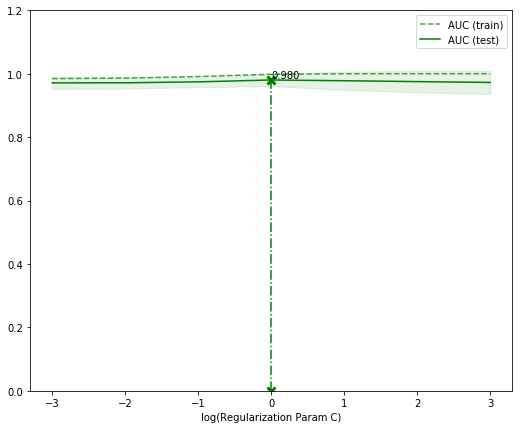

In [244]:
plot_auc(gsearch_lr)

**Refit the model with best C**

In [245]:
best_C = gsearch_lr.best_params_['C']
print('The best C is '+ str(best_C))

The best C is 1


In [246]:
best_AUC_lr = gsearch_lr.best_score_
print('The best AUC is '+ str(best_AUC_lr))

The best AUC is 0.9801560151874916


In [247]:
lr_ = LogisticRegression(penalty='l2', solver='liblinear', C=best_C, max_iter=1000,class_weight = 'balanced')
lr_ = lr_.fit(X = X_train, y = y_train)

**Investigate Coefficients**

Some of the words do not make sense because they are too event-specific

In [248]:
coef_df = pd.DataFrame({'variable':x_columns, 'coefficient':lr_.coef_[0]})
coef_df.sort_values(by = 'coefficient').head(10)

,variable,coefficient
7656,salmonella,-3.460950
6251,outbreak,-2.511981
1453,chicken,-2.078008
3201,february,-1.596218
4166,homemade,-1.565159
5473,meat,-1.527458
1906,cookie_dough,-1.480451
2745,egg,-1.473853
2687,eat_raw,-1.338956
5133,like,-1.246233


In [249]:
coef_df.sort_values(by = 'coefficient').tail(10)

,variable,coefficient
6086,nut_butter,2.554491
5924,nectarine,2.654673
7222,recall_pound,2.884865
3797,gold_medal,3.029194
6421,peach_nectarine,3.549054
661,baby_spinach,3.818809
1456,chicken_nugget,3.835997
3332,flour,4.546971
3695,general_mill,5.502666
7218,recall,7.695421


**Apply to test set**

In [879]:
print('There is a total of', len(df_test), 'in test set')
print('There is a total of', len(df_test_clean), 'in cleaned test set')
pred_probs = [x[1] for x in lr_.predict_proba(X_test)]
preds = lr_.predict(X_test)
print('There is a total of', sum(preds), 'predicted to be food-related events')

There is a total of 22840 in test set
There is a total of 21397 in cleaned test set
There is a total of 1297 predicted to be food-related events


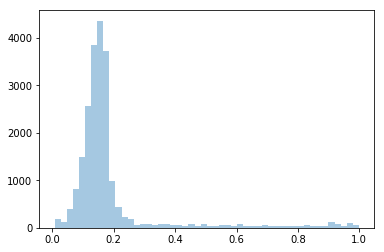

In [885]:
df_test_clean['preds'] = preds
df_test_clean['pred_probs'] = pred_probs
sns.distplot(pred_probs, kde = False)

# (Not used) Topic Modelling on test data

In [911]:
df_test_pred_true = df_test_clean[df_test_clean['preds'] == 1]

In [912]:
dictionary = corpora.Dictionary(df_test_pred_true['ab_clean_ph'])
print(dictionary)

Dictionary(801 unique tokens: ['additive', 'bacteria', 'dailyrecall', 'potentially_deadly', 'recall']...)


In [913]:
dictionary.filter_extremes(no_below = 3, no_above = 0.25)
print(dictionary)

Dictionary(280 unique tokens: ['bacteria', 'water', 'information', 'march', 'volkswagen']...)


In [916]:
corpus = [dictionary.doc2bow(text) for text in df_test_pred_true['ab_clean_ph']]
corpus[0]

[(0, 1), (1, 1)]

In [917]:
lda = LdaMulticore(corpus, num_topics = 4, id2word = dictionary)

In [ ]:
vis_data  = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

# (Not used) Supervised Model on `Event ID`

In [255]:
vectorizer = TfidfVectorizer(min_df=2, sublinear_tf=True)

In [267]:
text_tfidf = vectorizer.fit_transform([' '.join(text) for text in df_train['ab_clean_ph']])
X_train = text_tfidf
y_train = df_train['Event ID']

In [269]:
param_test_lr =  {'C' :[10 ** x for x in list(range(-4,5,1))]}
param_test_lr['C']
gsearch_lr = GridSearchCV(estimator = LogisticRegression( 
        penalty='l1', 
        solver='liblinear',
        max_iter=1000,
        class_weight = 'balanced'
    ),                   
    param_grid = param_test_lr, 
    cv = 5,
    n_jobs = 4)

gsearch_lr.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [274]:
gsearch_lr.best_params_

{'C': 1000}

In [273]:
gsearch_lr.best_score_

0.9792015300023906